In [9]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, RandomSampler
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from pathlib import Path
import cv2 as cv
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F

In [10]:
def check_jpg_counts(path):
    cnt = 0
    for dir_name in os.listdir(path):
        dir_path = os.path.join(path, dir_name)
        if os.path.isdir(dir_path):
            jpg_count = sum(1 for f in os.listdir(dir_path) if f.endswith(".jpg"))
            if jpg_count != 170:
                print(f"file {dir_name} has {jpg_count} number .jpg")
            cnt += jpg_count
    print('other files each 170 number .jpg')
    print(f"total {cnt} number .jpg")


# check the number of .jpg files in each directory
_dataset_dir = "./data/PIE"
check_jpg_counts(_dataset_dir)

file 38 has 164 number .jpg
other files each 170 number .jpg
total 11554 number .jpg


In [11]:
test_tfm = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # change own image to 1 channel
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


class FaceDataset(Dataset):

    def __init__(self, path, tfm=test_tfm, files=None):
        super(FaceDataset, self).__init__()
        self.path = path
        self.files = self._get_all_files(path) if files is None else files
        if len(self.files) == 0:
            raise ValueError(f"No .jpg files found in {path}")
        print(f"One {path} sample", self.files[0])
        self.transform = tfm

    def _get_all_files(self, path):
        """Recursively get all jpg files."""
        file_list = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg'):
                    file_list.append(os.path.join(root, file))
        return sorted(file_list)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        im = Image.open(fname)
        if self.transform:
            im = self.transform(im)
        try:
            label = int(fname.split("/")[-2])  # adjusted to get the parent directory as label
        except:
            label = -1  # test has no label
        return im, label


In [12]:
num_subject = 25
seed = 202311172359
subjects_index = np.random.default_rng(seed).choice(np.arange(1, 69), num_subject, replace=False)
# Load images 
image_data = []
label_data = []

directory = Path("../ca2/data/PIE")
for i in range(len(subjects_index)):
    # split train and test
    image_folder = []
    label_folder = []
    sub_file = directory / str(subjects_index[i])

    files = list(sub_file.glob("*.jpg"))
    np.random.default_rng(seed).shuffle(files)
    for filename in files:
        im = Image.open(filename)
        image_folder.append(np.array(im))
        label_folder.append(i)  # Use folder numbers as labels
    image_data.append(image_folder)
    label_data.append(label_folder)

print(subjects_index)

[18 46 32 42  6 15 33 64 23 39  7 54 53 28 58 11  3 17 52  2 67 49 20 66
 50]


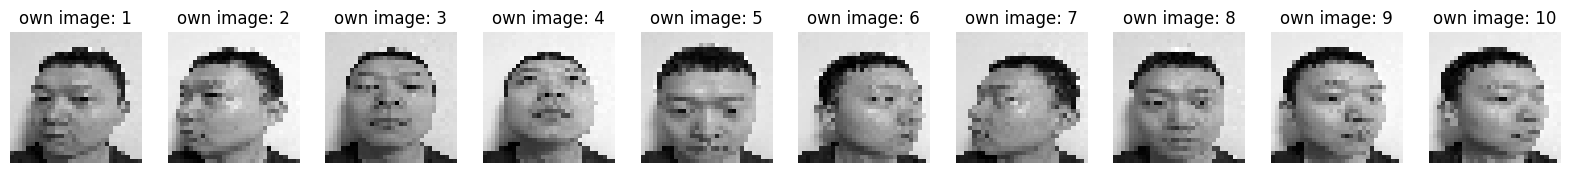

In [13]:
own_image_data = []
own_label_data = []

for i in range(1, 10 + 1):
    img = cv.imread('../ca2/data/own/69/' + str(i) + '.jpg', cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (32, 32), interpolation=cv.INTER_CUBIC)
    own_image_data.append(img)
    own_label_data.append(25)

# Split own photos into train and test sets
own_train_image_data = own_image_data[0:7]
own_test_image_data = own_image_data[7:]
own_train_label_data = own_label_data[0:7]
own_test_label_data = own_label_data[7:]

fig = plt.figure(figsize=(20, 10))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(own_image_data[i - 1], cmap='gray')
    plt.title('own photo' + str(i))
    plt.axis('off')

plt.show()

In [14]:
# Split PIE images into train and test sets
train_data_rate = np.int_(np.around(0.7 * 170))

image_data_train, image_data_test = np.split(np.array(image_data), [train_data_rate], axis=1)
label_data_train, label_data_test = np.split(np.array(label_data), [train_data_rate], axis=1)
own_image_data_train, own_image_data_test = np.split(np.array(own_image_data), [7])
own_label_data_train, own_label_data_test = np.split(np.array(own_label_data), [7])

import warnings
# ignore warnings for this part
warnings.filterwarnings('ignore', category=Warning)
# flatten_dim = 32 * 32
# Reshape to 2D arrays
main_image_data_train = image_data_train.reshape(num_subject * train_data_rate, 1, 32, 32)
own_image_data_train = own_image_data_train.reshape(7, 1, 32, 32)
image_data_test = image_data_test.reshape(num_subject * (170 - train_data_rate), 1, 32, 32)
own_image_data_test = own_image_data_test.reshape(3, 1, 32, 32)

label_data_train = label_data_train.reshape(num_subject * train_data_rate)
label_data_test = label_data_test.reshape(num_subject * (170 - train_data_rate))

# Combine PIE and own photos
full_train_image_set = np.append(main_image_data_train, own_image_data_train, axis=0, )
full_train_label_set = np.append(label_data_train, own_label_data_train)

full_test_image_set = np.append(image_data_test, own_image_data_test, axis=0, )
full_test_label_set = np.append(label_data_test, own_label_data_test)

In [15]:
# Define the model
class CNN_Layers(nn.Module):
    def __init__(self):
        super(CNN_Layers, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 20, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 50, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(50 * 5 * 5, 500),
            nn.ReLU(),
            nn.Linear(500, 26)
        )

    def forward(self, x):
        return self.net(x)


# Convert data to torch tensors and datasets
train_set = TensorDataset(torch.Tensor(full_train_image_set), torch.tensor(full_train_label_set).long())
test_set = TensorDataset(torch.Tensor(full_test_image_set), torch.tensor(full_test_label_set).long())

batch_size = 128
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)
model = CNN_Layers()

# Optimization
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)
criterion = nn.CrossEntropyLoss()


# Training loop
def train(model, train_loader, test_loader, optimizer, criterion, num_epochs=10, device=torch.device('cpu')):
    for epoch in range(num_epochs):

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        for batch in tqdm(train_loader):
            #     # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()
            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            # imgs = imgs.half()
            # print(imgs.shape,labels.shape)

            # Forward the data. (Make sure data and model are on the same device.)
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels)

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{num_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(test_loader):
            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            #imgs = imgs.half()

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)
            #break

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{num_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


In [16]:
# if you have cuda or mac mps, youcan change device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(model, train_loader, test_loader, optimizer, criterion)

100%|██████████| 24/24 [00:01<00:00, 19.39it/s]


[ Train | 001/010 ] loss = 4.16651, acc = 0.17664


100%|██████████| 10/10 [00:00<00:00, 84.06it/s]


[ Valid | 001/010 ] loss = 1.62540, acc = 0.61035


100%|██████████| 24/24 [00:01<00:00, 21.48it/s]


[ Train | 002/010 ] loss = 0.95135, acc = 0.72966


100%|██████████| 10/10 [00:00<00:00, 82.53it/s]


[ Valid | 002/010 ] loss = 0.39288, acc = 0.88819


100%|██████████| 24/24 [00:01<00:00, 21.54it/s]


[ Train | 003/010 ] loss = 0.29397, acc = 0.92176


100%|██████████| 10/10 [00:00<00:00, 80.29it/s]


[ Valid | 003/010 ] loss = 0.27110, acc = 0.91869


100%|██████████| 24/24 [00:01<00:00, 21.32it/s]


[ Train | 004/010 ] loss = 0.15449, acc = 0.95114


100%|██████████| 10/10 [00:00<00:00, 79.35it/s]


[ Valid | 004/010 ] loss = 0.13347, acc = 0.96324


100%|██████████| 24/24 [00:01<00:00, 21.39it/s]


[ Train | 005/010 ] loss = 0.07695, acc = 0.98165


100%|██████████| 10/10 [00:00<00:00, 84.22it/s]


[ Valid | 005/010 ] loss = 0.08981, acc = 0.98279


100%|██████████| 24/24 [00:01<00:00, 21.55it/s]


[ Train | 006/010 ] loss = 0.04808, acc = 0.98730


100%|██████████| 10/10 [00:00<00:00, 79.82it/s]


[ Valid | 006/010 ] loss = 0.22692, acc = 0.93743


100%|██████████| 24/24 [00:01<00:00, 21.42it/s]


[ Train | 007/010 ] loss = 0.05355, acc = 0.98535


100%|██████████| 10/10 [00:00<00:00, 81.30it/s]


[ Valid | 007/010 ] loss = 0.08245, acc = 0.97810


100%|██████████| 24/24 [00:01<00:00, 21.73it/s]


[ Train | 008/010 ] loss = 0.02034, acc = 0.99707


100%|██████████| 10/10 [00:00<00:00, 82.53it/s]


[ Valid | 008/010 ] loss = 0.08540, acc = 0.98276


100%|██████████| 24/24 [00:01<00:00, 21.23it/s]


[ Train | 009/010 ] loss = 0.02088, acc = 0.99740


100%|██████████| 10/10 [00:00<00:00, 83.47it/s]


[ Valid | 009/010 ] loss = 0.08341, acc = 0.98121


100%|██████████| 24/24 [00:01<00:00, 21.40it/s]


[ Train | 010/010 ] loss = 0.01318, acc = 0.99707


100%|██████████| 10/10 [00:00<00:00, 83.19it/s]

[ Valid | 010/010 ] loss = 0.08234, acc = 0.98513


# it also contains test part, in each epoch, it will run test part with no_grad(), therefore it will not affect the gradient.
# And the model in valid dataset has 0.97572 accuracy at last.